In [1]:
import os
import cv2
import random 
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import linear_kernel
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch.utils.data import *
from tqdm import tqdm 
import warnings 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


VGG Network 

In [3]:
# check pytorch cuda and use cuda if possible
device = torch.cuda.is_available()
print('*' * 50)
if torch.cuda.is_available():
    print('CUDA is found! Tranining on %s.......'%torch.cuda.get_device_name(0))
else:
    warnings.warn('CUDA not found! Training may be slow......')

**************************************************
CUDA is found! Tranining on Tesla P100-PCIE-16GB.......


In [4]:
path = '/content/drive/My Drive/Covid19-dataset'

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(path + '/train', train_transform)
test_data = datasets.ImageFolder(path + '/test', test_transform)

classes = train_data.classes

Classes: ['Covid', 'Normal', 'Viral Pneumonia'] 
Training samples: 251
Counts: {'Covid': 111, 'Normal': 70, 'Viral Pneumonia': 70}


<BarContainer object of 3 artists>

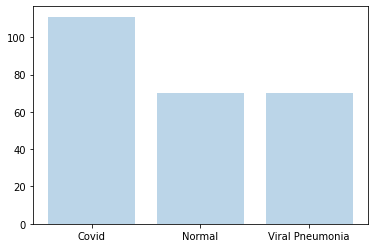

In [ ]:
classes_count = { c:0 for c in classes}
for _, label in train_data:
    classes_count[classes[label]] +=1

print(f'Classes: {classes} ')
print(f'Training samples: {len(train_data)}')
print(f'Counts: {classes_count}')
plt.bar(classes_count.keys(), classes_count.values(), alpha=0.3 )

Classes: ['Covid', 'Normal', 'Viral Pneumonia']
Testing samples: 66
Counts: {'Covid': 26, 'Normal': 20, 'Viral Pneumonia': 20}


<BarContainer object of 3 artists>

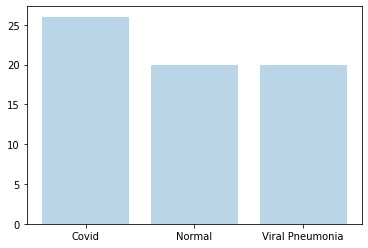

In [ ]:
classes_count_test = { c:0 for c in classes}
for _, label in test_data:
    classes_count_test[classes[label]] +=1

print(f'Classes: {classes}')
print(f'Testing samples: {len(test_data)}')
print(f'Counts: {classes_count_test}')
plt.bar(classes_count_test.keys(), classes_count_test.values(), alpha=0.3 )

In [ ]:
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([10, 3, 224, 224])
Samples from the training data: 


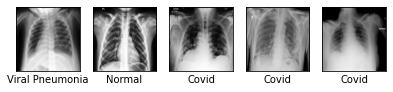

In [ ]:
images, labels = next(iter(train_loader))
print(images.shape)
print("Samples from the training data: ")

plt.figure(figsize=(8, 4))
for i, image in enumerate(images):
    plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0., 1.)
    plt.imshow(image)
    plt.xlabel(classes[int(labels[i].numpy())])
    if(i == 4):
        break

In [ ]:
class VGGNet(nn.Module):
    def __init__ (self):
        super(VGGNet,self).__init__()

        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(4608, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 3)

    def forward(self , x):
               
        x = F.relu(self.conv1_1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VGGNet()
model.to(device)

error = nn.CrossEntropyLoss()
learning_rate = 0.000008
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20

In [ ]:
print(model)

VGGNet(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=3, bias=True)
)


In [ ]:
def train(model, loader):
    
    model.train()
    epoch_loss = 0

    for i, (images, labels) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / (i + 1)

In [ ]:
def evaluate(model, loader):
    
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    #with torch.no_grad():
    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = error(outputs, labels)
        epoch_loss += loss.data
        predicted = torch.argmax(outputs, 1)
        total += len(labels)
        correct += (predicted == labels).sum()

    accuracy = 100 * correct / float(total)

    return epoch_loss / (i + 1), accuracy

In [ ]:
loss_train = []
accuracy_list = []
epoch_list = []

for epoch in tqdm(range(num_epochs)):
    
    train_loss = train(model, train_loader)
    test_loss, accuracy = evaluate(model, test_loader)
    
    loss_train.append(train_loss)
    accuracy_list.append(accuracy)
    epoch_list.append(epoch)

    print(f'Epoch: {epoch + 1}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tTest Loss: {test_loss:.3f}')
    print(f'\tTest accuracy: {accuracy:.4f}')

  5%|▌         | 1/20 [00:15<04:51, 15.33s/it]

Epoch: 1
	Train Loss: 1.093
	Test Loss: 1.094
	Test accuracy: 39.3939


 10%|█         | 2/20 [00:30<04:35, 15.29s/it]

Epoch: 2
	Train Loss: 1.086
	Test Loss: 1.086
	Test accuracy: 39.3939


 15%|█▌        | 3/20 [00:45<04:19, 15.25s/it]

Epoch: 3
	Train Loss: 1.067
	Test Loss: 1.051
	Test accuracy: 51.5152


 20%|██        | 4/20 [01:01<04:04, 15.30s/it]

Epoch: 4
	Train Loss: 0.939
	Test Loss: 0.819
	Test accuracy: 72.7273


 25%|██▌       | 5/20 [01:16<03:49, 15.30s/it]

Epoch: 5
	Train Loss: 0.553
	Test Loss: 0.586
	Test accuracy: 71.2121


 30%|███       | 6/20 [01:31<03:33, 15.25s/it]

Epoch: 6
	Train Loss: 0.353
	Test Loss: 0.597
	Test accuracy: 74.2424


 35%|███▌      | 7/20 [01:46<03:18, 15.24s/it]

Epoch: 7
	Train Loss: 0.319
	Test Loss: 0.466
	Test accuracy: 78.7879


 40%|████      | 8/20 [02:02<03:02, 15.23s/it]

Epoch: 8
	Train Loss: 0.246
	Test Loss: 0.448
	Test accuracy: 81.8182


 45%|████▌     | 9/20 [02:17<02:47, 15.25s/it]

Epoch: 9
	Train Loss: 0.241
	Test Loss: 0.491
	Test accuracy: 77.2727


 50%|█████     | 10/20 [02:32<02:32, 15.22s/it]

Epoch: 10
	Train Loss: 0.244
	Test Loss: 0.385
	Test accuracy: 83.3333


 55%|█████▌    | 11/20 [02:47<02:16, 15.21s/it]

Epoch: 11
	Train Loss: 0.254
	Test Loss: 0.455
	Test accuracy: 78.7879


 60%|██████    | 12/20 [03:02<02:01, 15.22s/it]

Epoch: 12
	Train Loss: 0.275
	Test Loss: 0.505
	Test accuracy: 78.7879


 65%|██████▌   | 13/20 [03:18<01:46, 15.24s/it]

Epoch: 13
	Train Loss: 0.223
	Test Loss: 0.410
	Test accuracy: 84.8485


 70%|███████   | 14/20 [03:33<01:31, 15.26s/it]

Epoch: 14
	Train Loss: 0.209
	Test Loss: 0.391
	Test accuracy: 84.8485


 75%|███████▌  | 15/20 [03:48<01:16, 15.26s/it]

Epoch: 15
	Train Loss: 0.217
	Test Loss: 0.461
	Test accuracy: 89.3939


 80%|████████  | 16/20 [04:04<01:01, 15.26s/it]

Epoch: 16
	Train Loss: 0.231
	Test Loss: 0.500
	Test accuracy: 83.3333


 85%|████████▌ | 17/20 [04:19<00:45, 15.26s/it]

Epoch: 17
	Train Loss: 0.166
	Test Loss: 0.378
	Test accuracy: 87.8788


 90%|█████████ | 18/20 [04:34<00:30, 15.26s/it]

Epoch: 18
	Train Loss: 0.158
	Test Loss: 0.373
	Test accuracy: 83.3333


 95%|█████████▌| 19/20 [04:49<00:15, 15.27s/it]

Epoch: 19
	Train Loss: 0.165
	Test Loss: 0.503
	Test accuracy: 81.8182


100%|██████████| 20/20 [05:05<00:00, 15.26s/it]

Epoch: 20
	Train Loss: 0.155
	Test Loss: 0.364
	Test accuracy: 86.3636


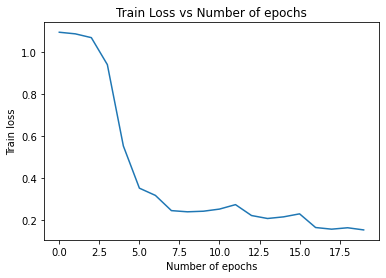

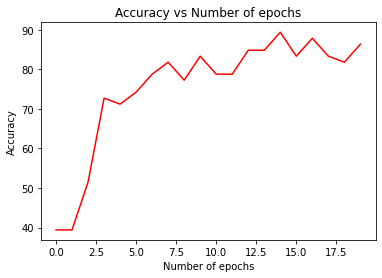

In [ ]:
plt.plot(epoch_list, loss_train)
plt.xlabel("Number of epochs")
plt.ylabel("Train loss")
plt.title("Train Loss vs Number of epochs")
plt.show()

plt.plot(epoch_list, accuracy_list, color = "red")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of epochs")
plt.show()

In [ ]:
predict_list = torch.tensor([]).to(device)
test_labels_list = torch.tensor([]).to(device)

for i, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    preds = torch.argmax(outputs, 1)

    predict_list = torch.cat((predict_list, preds), dim=-1)
    test_labels_list = torch.cat((test_labels_list, labels), dim=-1)

predict_list = predict_list.cpu().numpy()
test_labels_list = test_labels_list.cpu().numpy()

Test accuracy:  0.8636363636363636


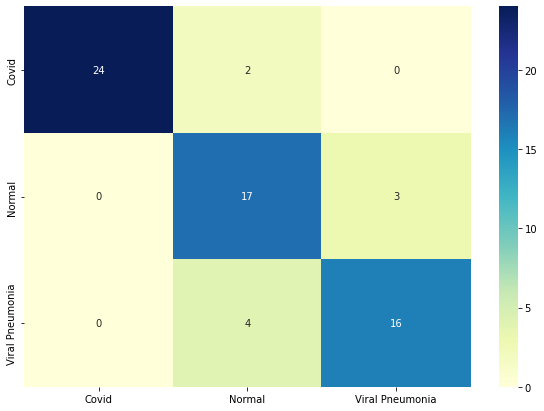

In [ ]:
print("Test accuracy: ", accuracy_score(predict_list, test_labels_list))

cmt = confusion_matrix(test_labels_list, predict_list)
df_cmt = pd.DataFrame(cmt, index = [i for i in train_data.classes], columns = [j for j in train_data.classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cmt, annot=True, cmap="YlGnBu")

SVM 

In [5]:
path_train = path + '/train'
path_test = path + '/test'

In [6]:
training_data = []
training_label = []

testing_data = []
testing_label = []
img_size = 224

for class_ in classes:
    train_path = os.path.join(path_train, class_)
    class_label = classes.index(class_)
    for img in os.listdir(train_path):
        img_array = cv2.imread(os.path.join(train_path, img))
        new_array = cv2.resize(img_array,(img_size, img_size))
        training_data.append(new_array)
        training_label.append(class_label)

for class_ in classes:
    test_path = os.path.join(path_test, class_)
    class_label = classes.index(class_)
    for img in os.listdir(test_path):
        img_array = cv2.imread(os.path.join(test_path, img))
        new_array = cv2.resize(img_array,(img_size, img_size))
        testing_data.append(new_array)
        testing_label.append(class_label)

In [7]:
X_train = np.array(training_data).reshape(len(training_data), -1)
y_train = np.array(training_label)

X_test = np.array(testing_data).reshape(len(testing_data), -1)
y_test = np.array(testing_label)

In [8]:
def train_svm(X, y, kernel, C = 10):

    m, n = X.shape
    y = y.reshape(-1,1) * 1.
    if kernel == 'rbf':
        K = rbf_kernel(X, gamma = 10)
        H = y * K 
        H = H * y.T
    else:
        K = linear_kernel(X)
        H = y * K 
        H = H * y.T
    P = matrix(H)
    q = matrix(-np.ones((m, 1)))
    G = matrix(np.vstack((np.eye(m)*-1, np.eye(m))))
    h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    
    solvers.options['show_progress'] = False

    return solvers.qp(P, q, G, h, A, b)

def get_parameters(X, y, alphas):

    y = y.reshape(-1,1)
    threshold = 1e-12 # Values greater than zero (some floating point tolerance)
    w = ((y * alphas).T @ X).reshape(-1,1)
    S = (alphas > threshold).flatten()
    b = y[S] - np.dot(X[S], w)

    return w, b[0]

In [9]:
y_train_1 = []
y_train_2 = []
y_train_3 = []
for i in range(y_train.shape[0]):
    if y_train[i] == 0:
        y_train_1.append(1)
    else:
        y_train_1.append(-1)
y_train_1 = np.array(y_train_1)

for i in range(y_train.shape[0]):
    if y_train[i] == 1:
        y_train_2.append(1)
    else:
        y_train_2.append(-1)
y_train_2 = np.array(y_train_2)

for i in range(y_train.shape[0]):
    if y_train[i] == 2:
        y_train_3.append(1)
    else:
        y_train_3.append(-1)
y_train_3 = np.array(y_train_3)

In [10]:
sol0 = train_svm(X_train, y_train_1, 'rb')
alphas0 = np.array(sol0['x'])
w0, b0 = get_parameters(X_train, y_train_1, alphas0)

sol1 = train_svm(X_train, y_train_2, 'rb')
alphas1 = np.array(sol1['x'])
w1, b1 = get_parameters(X_train, y_train_2, alphas1)

sol2 = train_svm(X_train, y_train_3, 'rb')
alphas2 = np.array(sol2['x'])
w2, b2 = get_parameters(X_train, y_train_3, alphas2)

In [11]:
pred_test = []
count = 0
for data in X_test:
    count += 1
    data = data.reshape(1, -1)
    res_0 = np.dot(data, w0) + b0
    res_1 = np.dot(data, w1) + b1
    res_2 = np.dot(data, w2) + b2

    res_list = [res_0, res_1, res_2]
    tmp = max(res_list)
    index = res_list.index(tmp)
    pred_test.append(index)

pred_test = np.array(pred_test)

Test accuracy:  0.6363636363636364


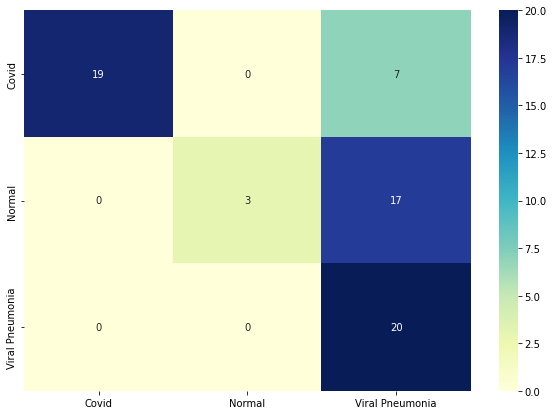

In [12]:
print("Test accuracy: ", accuracy_score(y_test, pred_test))

mat = confusion_matrix(y_test, pred_test)
df_mat = pd.DataFrame(mat, index = [i for i in train_data.classes], columns = [j for j in train_data.classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_mat, annot=True, cmap="YlGnBu")

In [13]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_auc_score

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=0, C=10)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


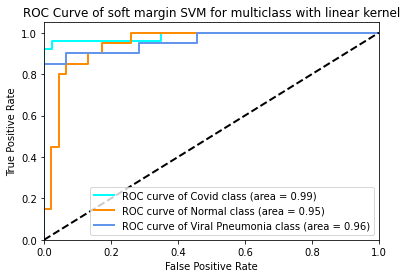

In [20]:
# Compute ROC curve and ROC area for each class

class_labels = ['Covid', 'Normal', 'Viral Pneumonia']
y_test_2 = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_2.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_2[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

# Plot all ROC curves
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of {0} class (area = {1:0.2f})".format(class_labels[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of soft margin SVM for multiclass with linear kernel")
plt.legend(loc="lower right")
plt.show()